In [14]:
from pathlib import Path
from functools import lru_cache

from joblib import Parallel, delayed, Memory
import numpy as np
import matplotlib.pyplot as plt

from src.model.calculate_chip_temp import calculate_parameters

In [15]:
fig_dir = Path("Figures/")

memory = Memory(location=Path("cache"), verbose=0)
# @lru_cache(maxsize=32)
def _calculate_parameters_cached(
    width, height, l_in, l_chip, l_out, t_in, airflow, q_chip, fluid_name
):
    """Cache the results of the calculation for a given set of parameters"""
    t_chip, t_mid_chip, t_out = memory.cache(calculate_parameters)(
        w=width,
        h=height,
        l_in=l_in,
        l_chip=l_chip,
        l_out=l_out,
        t_in=t_in,
        v_dot=airflow,
        q=q_chip,
        fluid_name=fluid_name,
    )
    return t_chip - 273.15, t_mid_chip - 273.15, t_out - 273.15

def __calculate_parameters_cached(inputs):
    """Calculate the parameters for a given set of parameters"""
    return _calculate_parameters_cached(**inputs)


def _calculate_parameters_parallel(input_sets):
    """Calculate the parameters for a given set of parameters in parallel"""
    return Parallel(n_jobs=-3)(
        delayed(__calculate_parameters_cached)(input_set) for input_set in input_sets
    )

In [16]:
total_length = 0.4826
chip_length = 0.0375
segment_length = (total_length - chip_length) / 2

base_parameters = {
    "width": 0.4826,
    "height": 0.015875,
    "l_in": segment_length,
    "l_chip": chip_length,
    "l_out": segment_length,
    "t_in": 300,
    "airflow": 0.135,
    "q_chip": 75,
    "fluid_name": "air",
}

key_to_axis_label = {
    "width": "Width (m)",
    "height": "Height (m)",
    "t_in": "Inlet Temperature (°C)",
    "airflow": "Volumetric Flow Rate ($m^3$/s)",
    "q_chip": "Chip Heat (W)",
    "l_chip": "Chip Length (m)",
    "length": "Length (m)",
}


def _adjust_base_parameters(base_parameters, key, value):
    new_parameters = base_parameters.copy()
    if key == "length":
        chip_length = 0.0375
        segment_length = (value - chip_length) / 2
        new_parameters["l_in"] = segment_length
        new_parameters["l_chip"] = chip_length
        new_parameters["l_out"] = segment_length
    elif key == "l_chip":
        segment_length = (total_length - value) / 2
        new_parameters["l_in"] = segment_length
        new_parameters["l_chip"] = value
        new_parameters["l_out"] = segment_length
    else:
        new_parameters[key] = value
    return new_parameters


def _parameters_range(key, start, stop, step, base_parameters=base_parameters):
    return [
        _adjust_base_parameters(base_parameters, key, value)
        for value in np.arange(start, stop, step)
    ]


def _get_alternative_fluid_parameters(parameters, fluid_name):
    return [
        _adjust_base_parameters(parameter, "fluid_name", fluid_name)
        for parameter in parameters
    ]


def plot_range(key, start, stop, step, sf6=True, value="t_chip",ax=None):
    if value == "t_chip":
        i = 0
    elif value == "t_mid_chip":
        i = 1   
    elif value == "t_out":
        i = 2
    
    air_parameters = _parameters_range(key, start, stop, step)
    temperatures_air = _calculate_parameters_parallel(air_parameters)
    temperatures_air = [temperature[i] for temperature in temperatures_air]

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(
        np.arange(start, stop, step),
        len(temperatures_air) * [base_parameters["t_in"] - 273.15],
        label="Inlet Temperature",
    )
    ax.plot(np.arange(start, stop, step), temperatures_air, label="Air")

    axis_label = key_to_axis_label[key]
    ax.set_xlabel(axis_label)
    
    if value == "t_chip":
        ax.set_ylabel("Chip Temperature (°C)")
    elif value == "t_mid_chip":
        ax.set_ylabel("Mid Channel Temperature (°C)")
    elif value == "t_out":
        ax.set_ylabel("Outlet Temperature (°C)")
        
    if sf6:
        sf6_parameters = _get_alternative_fluid_parameters(air_parameters, "sf6")
        temperatures_sf6 = _calculate_parameters_parallel(sf6_parameters)
        temperatures_sf6 = [temperature[i] for temperature in temperatures_sf6]
        ax.plot(np.arange(start, stop, step), temperatures_sf6, label="SF$_6$")
    # ax.title(f"Temperature vs {axis_label}")

    if ax is None:
        ax.legend() 
        fig.savefig(
            fig_dir / f"{value}_{key}_{start}_{step}_{stop}.pdf", dpi=300, bbox_inches="tight"
        )
    
def plot_range_all(key, start, stop, step, sf6=True):
    [plot_range(key, start, stop, step, sf6, value) for value in ["t_chip", "t_mid_chip", "t_out"]]

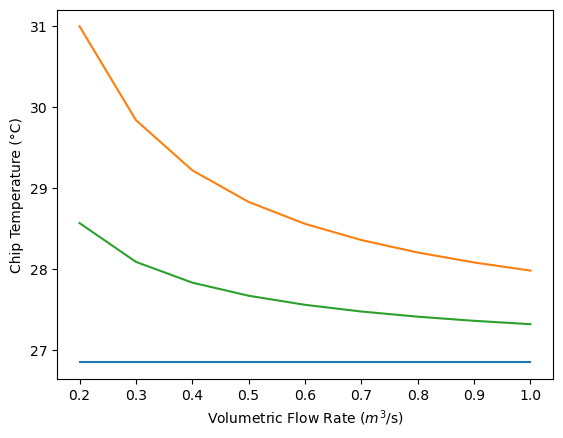

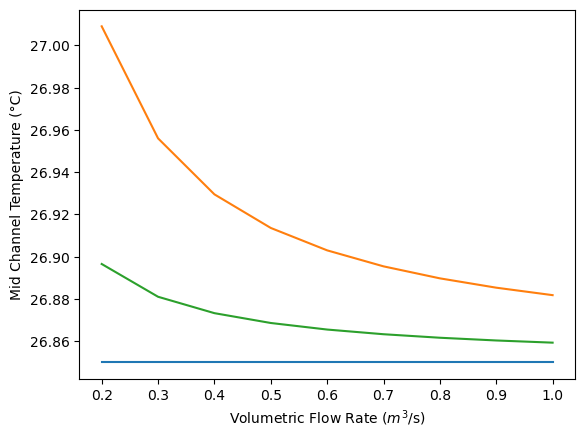

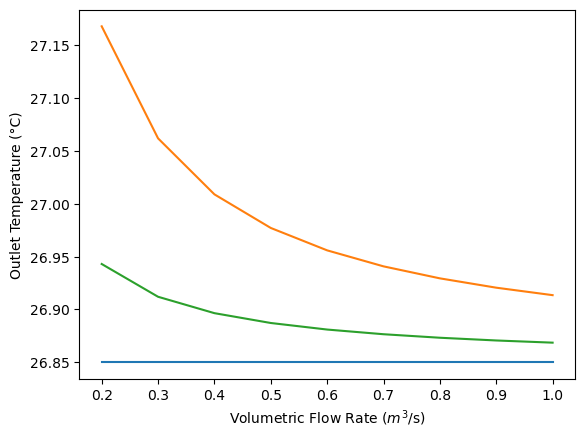

In [17]:
plot_range_all("airflow", 0.2, 1.1, 0.1)

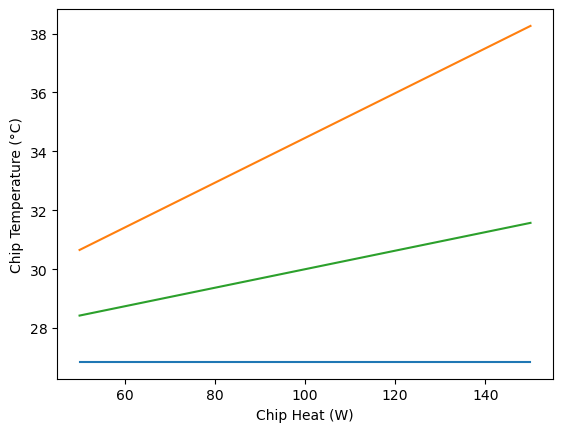

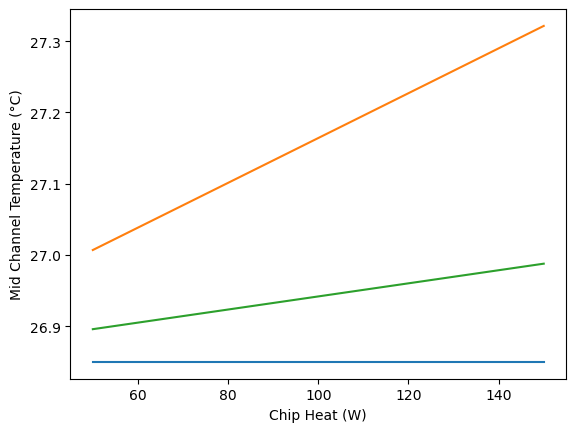

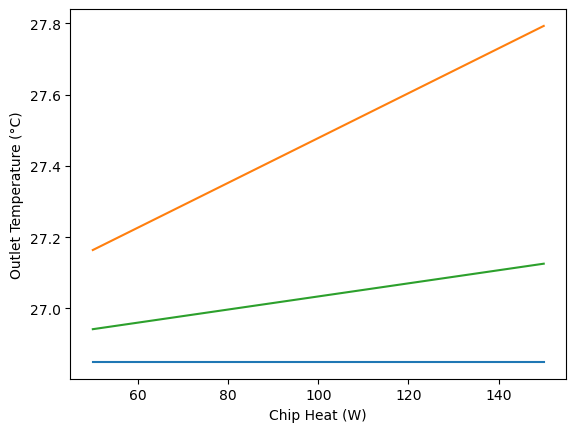

In [18]:
plot_range_all("q_chip", 50, 175, 25)

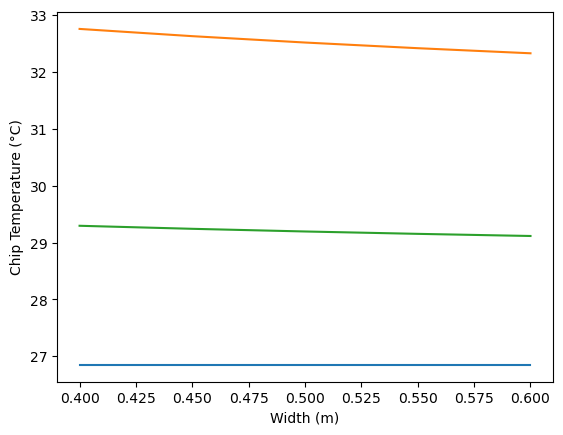

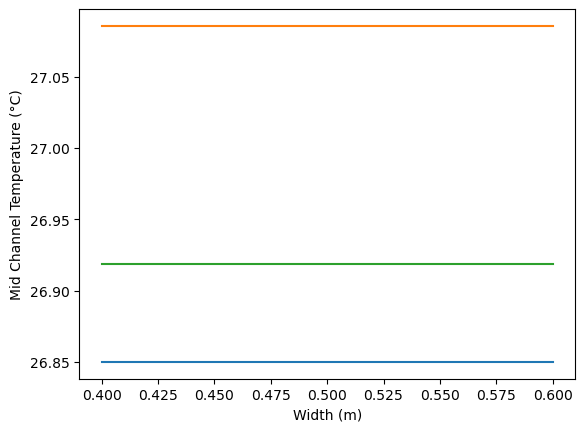

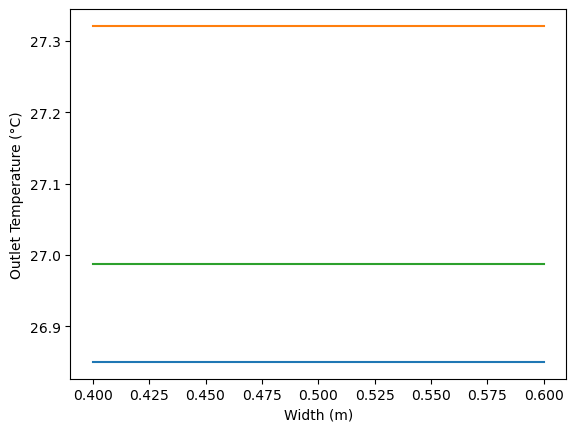

In [19]:
plot_range_all("width", 0.4, 0.65, 0.05)

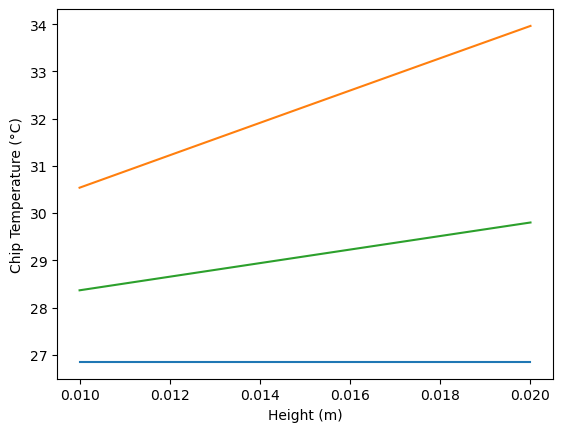

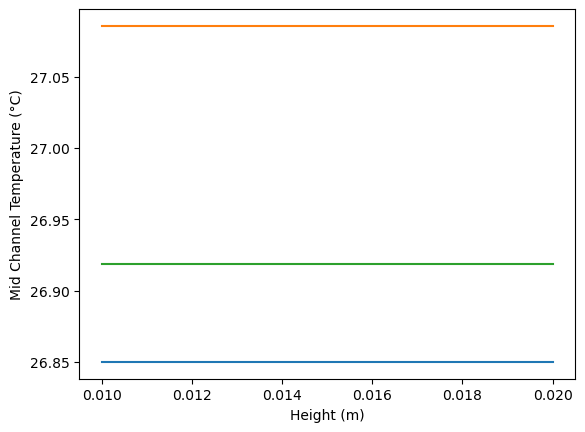

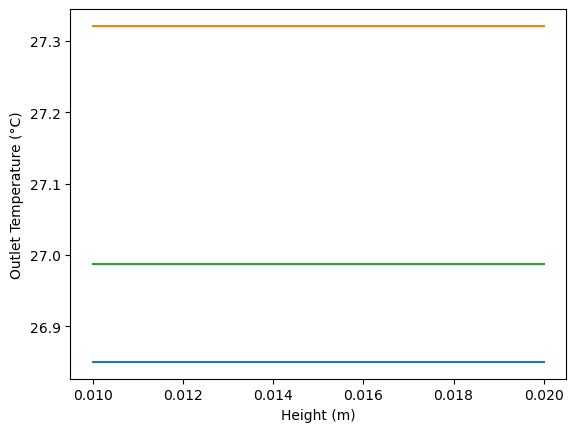

In [20]:
plot_range_all("height", 0.01, 0.0225, 0.0025, sf6=True)

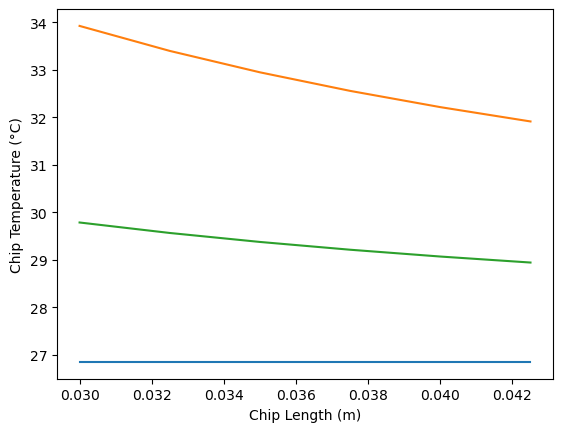

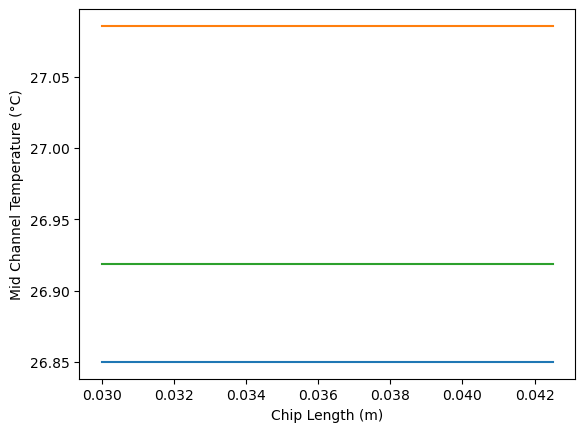

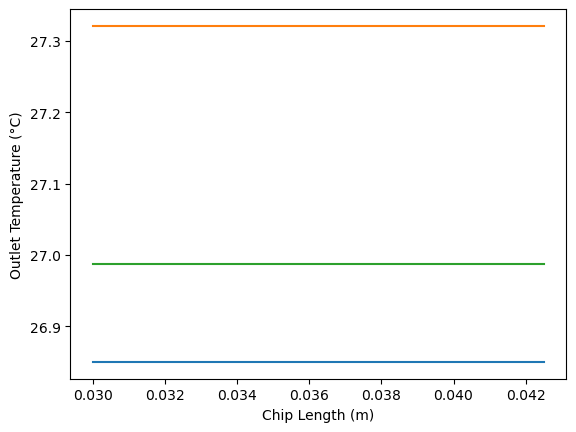

In [21]:
plot_range_all("l_chip", 0.03, 0.0425, 0.0025, sf6=True)

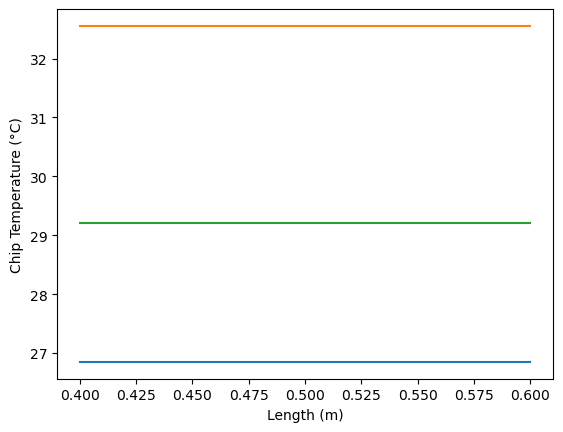

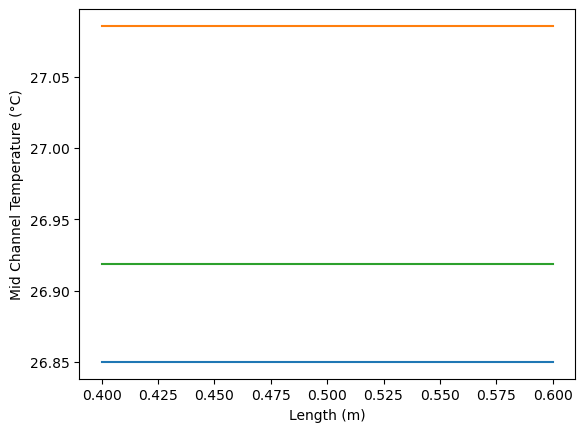

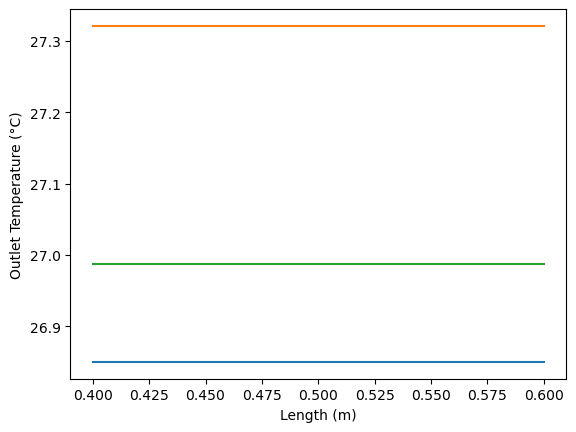

In [22]:
plot_range_all("length", 0.4, 0.65, 0.05, sf6=True)

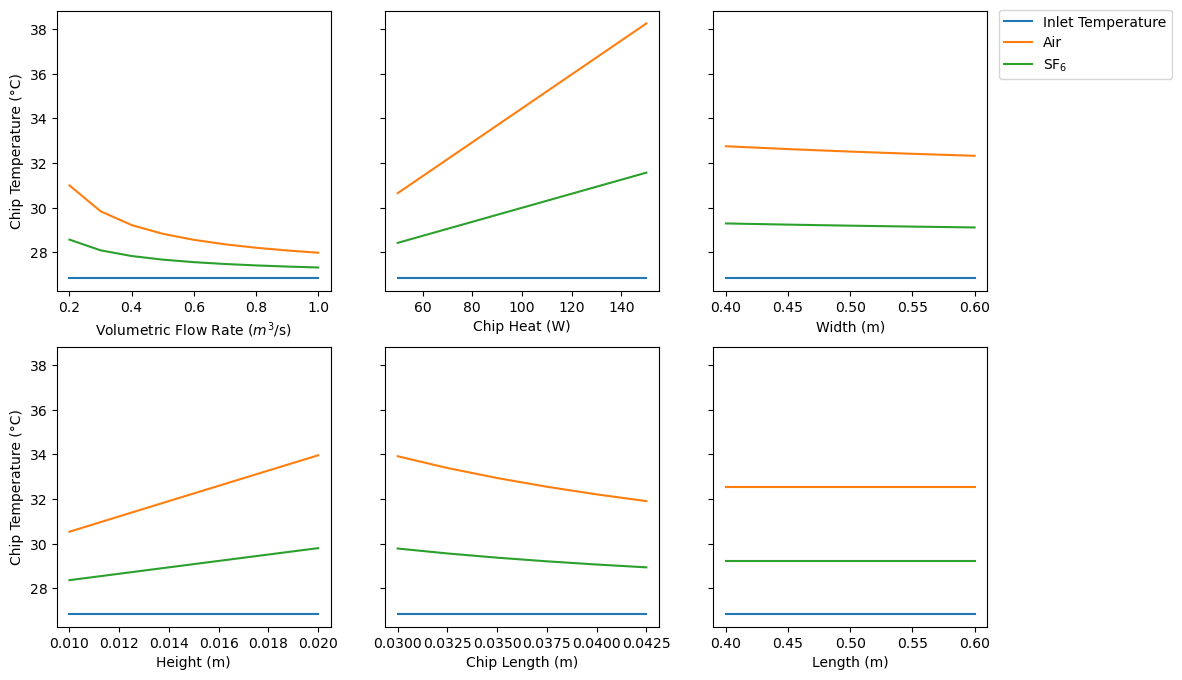

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
plot_range("airflow", 0.2, 1.1, 0.1, sf6=True, value="t_chip", ax=ax[0,0])
plot_range("q_chip", 50, 175, 25, sf6=True, value="t_chip", ax=ax[0,1])
plot_range("width", 0.4, 0.65, 0.05, sf6=True, value="t_chip", ax=ax[0,2])
ax[0,1].set_ylabel("")
ax[0,2].set_ylabel("")
plot_range("height", 0.01, 0.0225, 0.0025, sf6=True, value="t_chip", ax=ax[1,0])
plot_range("l_chip", 0.03, 0.0425, 0.0025, sf6=True, value="t_chip", ax=ax[1,1])
plot_range("length", 0.4, 0.65, 0.05, sf6=True, value="t_chip", ax=ax[1,2])
ax[1,1].set_ylabel("")
ax[1,2].set_ylabel("")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.56, 0.39, 0.5, 0.5))

fig.savefig(fig_dir / "all.pdf", dpi=300, bbox_inches="tight")